# GP Initial Implementation: GPyTorch

In [11]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [12]:
# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize data
df.loc[df['num'] != 0, 'num'] = 1

In [13]:
# Define features and target vectors
X = df.iloc[:,:-1].values
y = df['num'].values

In [14]:
# Import specifics
import math
import torch
import gpytorch

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

In [15]:
# Split train and test data
Test_Size = 0.2
Random_Seed = 82024

index = list(range(y.size))
train_index, test_index = train_test_split(index, test_size=Test_Size, random_state=Random_Seed)

train_df = df.loc[train_index]
test_df = df.loc[test_index]

In [16]:
# Create PyTorch tensors for X and y
train_X = torch.tensor(train_df.iloc[:,:-1].values)
train_y = torch.tensor(train_df['num'].values).double()

test_X = torch.tensor(test_df.iloc[:,:-1].values)
test_y = torch.tensor(test_df['num'].values).double()

In [17]:
# Create model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_X, train_y, likelihood)

In [18]:
# Train model
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
loss_list = []
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_X)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    loss_list.append(loss.tolist())
    optimizer.step()

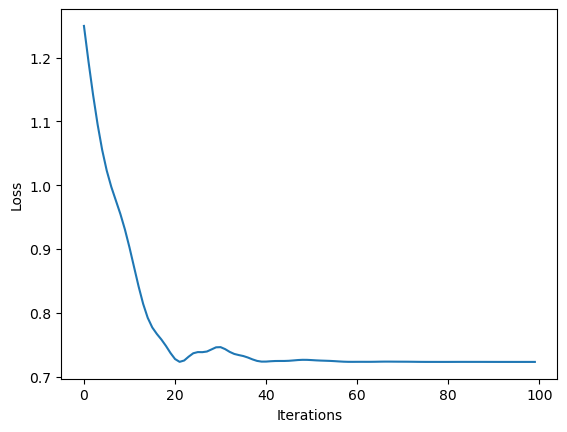

In [19]:
# Plot loss values
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [20]:
# Test model
model.eval()
likelihood.eval()

with torch.no_grad():
    y_pred = likelihood(model(test_X))
    pred_probs = y_pred.mean.numpy()

    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (pred_probs >= 0.5).astype(int)

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y.numpy(), pred_probs)

print(f"Accuracy: {acc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.55
ROC AUC: 0.50
